#Business Understanding

Safaricom's procurement function spans multiple departments, suppliers, and categories — often with varying levels of spend control and oversight. In today’s competitive and cost-sensitive environment, the CFO and leadership team require actionable insights into where money is going, who is spending it, and whether that spend is aligned with strategic priorities such as efficiency, digital transformation, and sustainability.

The goal is to establish a data-driven procurement intelligence system that:

Tracks purchase order (PO) trends over time,

Identifies cost-saving levers,

Highlights supplier performance and risk,

Supports proactive, not reactive, financial decisions.



# Problem Statement

Despite extensive procurement activity, the current visibility into spend data is fragmented and lacks granularity. Key challenges include:

1. Inconsistent classification of spend categories

2. Lack of consolidated supplier insights and trend tracking,

3. Difficulty comparing actual spend versus budget due to missing baseline alignment,

4. No forward-looking spend forecast or variance explanation.

#Objectives


1	Determine the total spend during the review period

2 Perform monthly trend analysis to highlight spikes or anomalies

3	Estimate future spending using current trends

4	Recommend cost-saving opportunities

5	Evaluate strategic alignment of spend with business goals

In [ ]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import json
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import  TfidfVectorizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings("ignore")

# Data Understanding


In [ ]:
# Loading dataset
df = pd.read_excel("/content/Working Data.xlsx")
df.head()

In [ ]:
pd.set_option('display.max_columns',45)

In [ ]:
df.shape

In [ ]:
df.describe()

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8058 entries, 0 to 8057
Data columns (total 45 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   OU Name                                                 8058 non-null   object        
 1   PO                                                      8058 non-null   int64         
 2   Month                                                   8058 non-null   datetime64[ns]
 3   PO/Release creation method                              8058 non-null   object        
 4   Supplier/Vendor                                         8058 non-null   object        
 5   Item Description                                        8058 non-null   object        
 6   Main category                                           8058 non-null   object        
 7   Sub-category                                            8058

# Data Cleaning

In [150]:
df.isna().sum()

,0
OU Name,0
PO,0
Month,0
PO/Release creation method,0
Supplier/Vendor,0
Item Description,0
Main category,0
Sub-category,0
Product Type,0
Product Name,0


Text(0.5, 1.0, 'Correlation Heatmap (Numerical Features Only)')

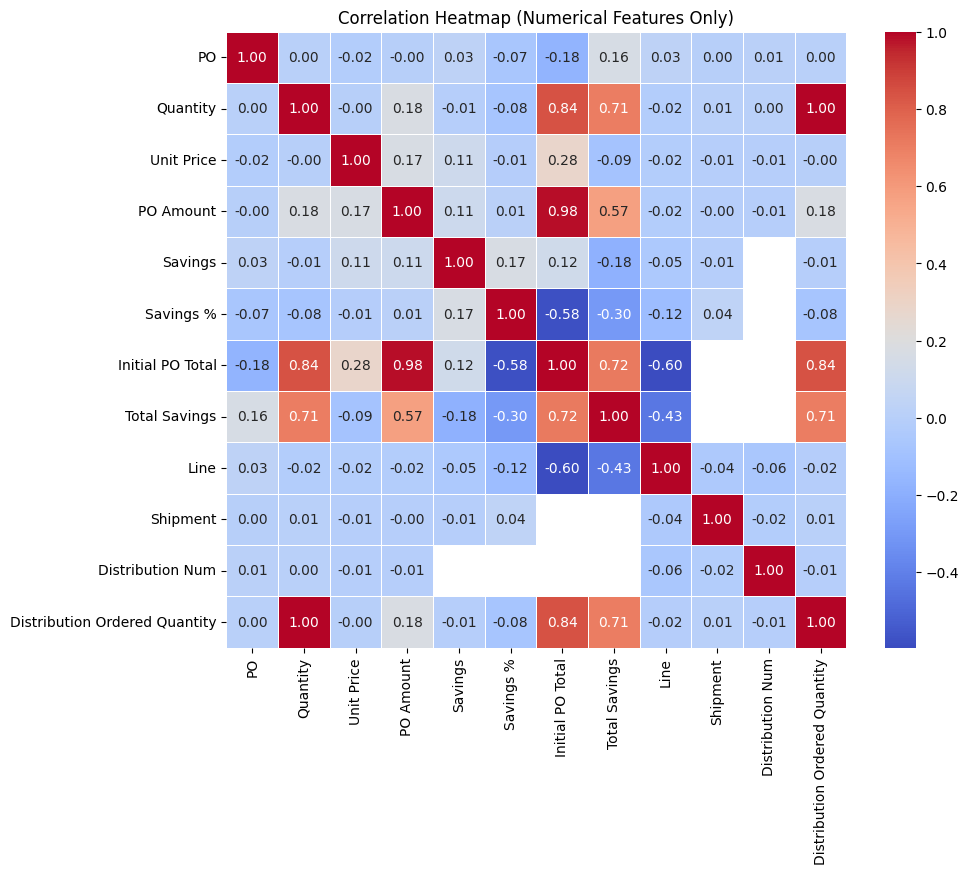

In [151]:
# Correlation matrix to check for the columns with the highest or lowest correlation
numeric_df = df.select_dtypes(include="number")

corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Numerical Features Only)")


In [152]:
#percentage of null values
null_percent = (df.isnull().sum() / len(df)) * 100
print(null_percent)

OU Name                                                    0.000000
PO                                                         0.000000
Month                                                      0.000000
PO/Release creation method                                 0.000000
Supplier/Vendor                                            0.000000
Item Description                                           0.000000
Main category                                              0.000000
Sub-category                                               0.000000
Product Type                                               0.000000
Product Name                                               0.000000
UOM                                                        1.439563
Currency                                                   0.000000
Quantity                                                   0.000000
Unit Price                                                 1.439563
PO Amount                                       

In [153]:
# Dropping all columns that has more than 90% missing values
df = df.loc[:, df.isnull().mean() < 0.9]


In [154]:
df = df.drop(columns = ['Supplier Site'])

In [155]:
df = df.dropna(subset=['UOM', 'Unit Price', 'Distribution Ordered Quantity'])


In [156]:
df.head()

,OU Name,PO,Month,PO/Release creation method,Supplier/Vendor,Item Description,Main category,Sub-category,Product Type,Product Name,UOM,Currency,Quantity,Unit Price,PO Amount,Addressable or Non-Addressable,Locale(Foreign or Local based Suppliers),Special Interest Group- Women or Youth Owned Suppliers,Category Manager(s),Buyer,Closure Status,Type,Line,Shipment,Distribution Num,Distribution Ordered Quantity,Financial Year,Department,Division,Expenditure Type
0,MPESA Foundation,1358,2024-08-01,Manual,FF,return airport transfers in Nairobi,CORPORATE SERVICES,HR & STAFF WELFARE,TRAVEL & ACCOMODATION,DOMESTIC FLIGHTS,Each,KES,1.0,2800.00,2800.00,Addressable,Local,Others,Muchiri Thomas,"Rowa, Ms. Beverly Akinyi",OPEN,Goods,2,1,1,1.0,FY 2024/25,NaN,NaN,Opex
1,MPESA Foundation,1359,2024-08-01,Manual,OOOOOOOOP,Accomodation for foundation team during offsit...,CORPORATE SERVICES,HR & STAFF WELFARE,TRAVEL & ACCOMODATION,DOMESTIC FLIGHTS,Each,KES,43.0,17578.13,755859.59,Addressable,Local,Others,Muchiri Thomas,"Rowa, Ms. Beverly Akinyi",OPEN,Goods,1,1,1,43.0,FY 2024/25,NaN,NaN,Opex
2,MPESA Foundation,1359,2024-08-01,Manual,BNM,C L 2,CORPORATE SERVICES,HR & STAFF WELFARE,TRAVEL & ACCOMODATION,DOMESTIC FLIGHTS,Each,KES,43.0,351.56,15117.08,Addressable,Local,Others,SALOME,"Rowa, Ms. Beverly Akinyi",OPEN,Goods,2,1,1,43.0,FY 2024/25,NaN,NaN,Opex
3,MPESA Foundation,1359,2024-08-01,Manual,FFG,S C,CORPORATE SERVICES,HR & STAFF WELFARE,TRAVEL & ACCOMODATION,DOMESTIC FLIGHTS,Each,KES,43.0,1757.81,75585.83,Addressable,Local,Others,Muchiri Thomas,"Rowa, Ms. Beverly Akinyi",OPEN,Goods,3,1,1,43.0,FY 2024/25,NaN,NaN,Opex
4,MPESA Foundation,1359,2024-08-01,Manual,FFG,Karen Basiye,CORPORATE SERVICES,HR & STAFF WELFARE,TRAVEL & ACCOMODATION,DOMESTIC FLIGHTS,Each,KES,3.0,20703.13,62109.39,Addressable,Local,Others,Muchiri Thomas,"Rowa, Ms. Beverly Akinyi",OPEN,Goods,4,1,1,3.0,FY 2024/25,NaN,NaN,Opex


In [157]:
df.isna().sum()

,0
OU Name,0
PO,0
Month,0
PO/Release creation method,0
Supplier/Vendor,0
Item Description,0
Main category,0
Sub-category,0
Product Type,0
Product Name,0


In [158]:
df['Department'] = df['Department'].fillna('Unknown')
df['Division'] = df['Division'].fillna('Unknown')

In [159]:
df.duplicated().sum()

np.int64(0)

In [160]:
# Check for entry variants
for col in df.select_dtypes(include='object').columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print("-" * 40)

Column: OU Name
['MPESA Foundation' 'DigiFarm Kenya Limited' 'M-PESA AFRICA LIMITED'
 'M-PESA SA (PTY) Limited' 'Safaricom' 'Safaricomm' 'Safaricom.']
----------------------------------------
Column: PO/Release creation method
['Manual' 'Touchless' 'Autocreate']
----------------------------------------
Column: Supplier/Vendor
['FF' 'OOOOOOOOP' 'BNM' 'FFG' 'G' 'LLLKKJJJ' 'ZZZZZZZZZZZZ' 'AA' 'DD'
 'VGJ' 'PLK' 'BNG' 'BVGT' 'LLLLLLLL' 'DFH' 'VBN' 'MMJ' 'ZZZZ' 'FGT' 'HJ'
 'CFG' 'VBYI' 'BHJP' 'CVGHJ' 'FVG' 'GG' 'HH' 'VBK' 'VGHKKL' 'CVB' 'BN'
 'YPY' 'GBJJKKPP' 'VBBKKLL' 'CVD' 'KK' 'TYU' 'GHJ' 'FCH' 'FG' 'DF' 'RTIO'
 'JKL' 'HJKL' 'YOU' 'WE' 'FRTY' 'KLP' 'NMJ' 'BHJ' 'GFF' 'BHHY' 'CVXXXXX'
 'DFG' 'RTY' 'GHY' 'ERY' 'FT' 'GHKL' 'LLK' 'ZZZCG' 'BBBBBBBB' 'FCV']
----------------------------------------
Column: Item Description
['return airport transfers in Nairobi'
 'Accomodation for foundation team during offsite meeting 6th to 8th Aug 2pax'
 'C L 2 ' ... 'Kakamega Golf Hotel Single HB Deluxe Room'


In [161]:
df['OU Name'] = df['OU Name'].str.strip().replace({
    'Safaricomm': 'Safaricom',
    'Safaricom.': 'Safaricom'
})

In [162]:
df['Main category'] = df['Main category'].str.upper().str.replace(r'[.]$', '', regex=True).str.strip()
df['Main category'] = df['Main category'].replace({
    'CORPORATE SERVICESS': 'CORPORATE SERVICES',
    'CORPORATE SERVICE': 'CORPORATE SERVICES',
    'CORPORATE SERVICES.': 'CORPORATE SERVICES',
    'CORPRATE SERVICES': 'CORPORATE SERVICES',
    'CORPORATE Services': 'CORPORATE SERVICES',
    'TECHNOLOGY NETWORKSS': 'TECHNOLOGY NETWORKS'
})

In [163]:
df['Expenditure Type'] = df['Expenditure Type'].str.lower().str.strip()
df['Expenditure Type'] = df['Expenditure Type'].replace({
    'capexx': 'capex',
    'opex': 'opex',
    'Opex': 'opex',
    'Capex': 'capex'
})

In [164]:
df['Financial Year'] = df['Financial Year'].str.replace('//', '/').str.strip()

In [165]:
for col in df.select_dtypes(include='object').columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print("-" * 40)

Column: OU Name
['MPESA Foundation' 'DigiFarm Kenya Limited' 'M-PESA AFRICA LIMITED'
 'M-PESA SA (PTY) Limited' 'Safaricom']
----------------------------------------
Column: PO/Release creation method
['Manual' 'Touchless' 'Autocreate']
----------------------------------------
Column: Supplier/Vendor
['FF' 'OOOOOOOOP' 'BNM' 'FFG' 'G' 'LLLKKJJJ' 'ZZZZZZZZZZZZ' 'AA' 'DD'
 'VGJ' 'PLK' 'BNG' 'BVGT' 'LLLLLLLL' 'DFH' 'VBN' 'MMJ' 'ZZZZ' 'FGT' 'HJ'
 'CFG' 'VBYI' 'BHJP' 'CVGHJ' 'FVG' 'GG' 'HH' 'VBK' 'VGHKKL' 'CVB' 'BN'
 'YPY' 'GBJJKKPP' 'VBBKKLL' 'CVD' 'KK' 'TYU' 'GHJ' 'FCH' 'FG' 'DF' 'RTIO'
 'JKL' 'HJKL' 'YOU' 'WE' 'FRTY' 'KLP' 'NMJ' 'BHJ' 'GFF' 'BHHY' 'CVXXXXX'
 'DFG' 'RTY' 'GHY' 'ERY' 'FT' 'GHKL' 'LLK' 'ZZZCG' 'BBBBBBBB' 'FCV']
----------------------------------------
Column: Item Description
['return airport transfers in Nairobi'
 'Accomodation for foundation team during offsite meeting 6th to 8th Aug 2pax'
 'C L 2 ' ... 'Kakamega Golf Hotel Single HB Deluxe Room'
 'Kakamega Golf Service Ch

In [166]:
df.shape

(7942, 30)

In [167]:
# Outliers
numeric_df =df.select_dtypes(include = ['number'])

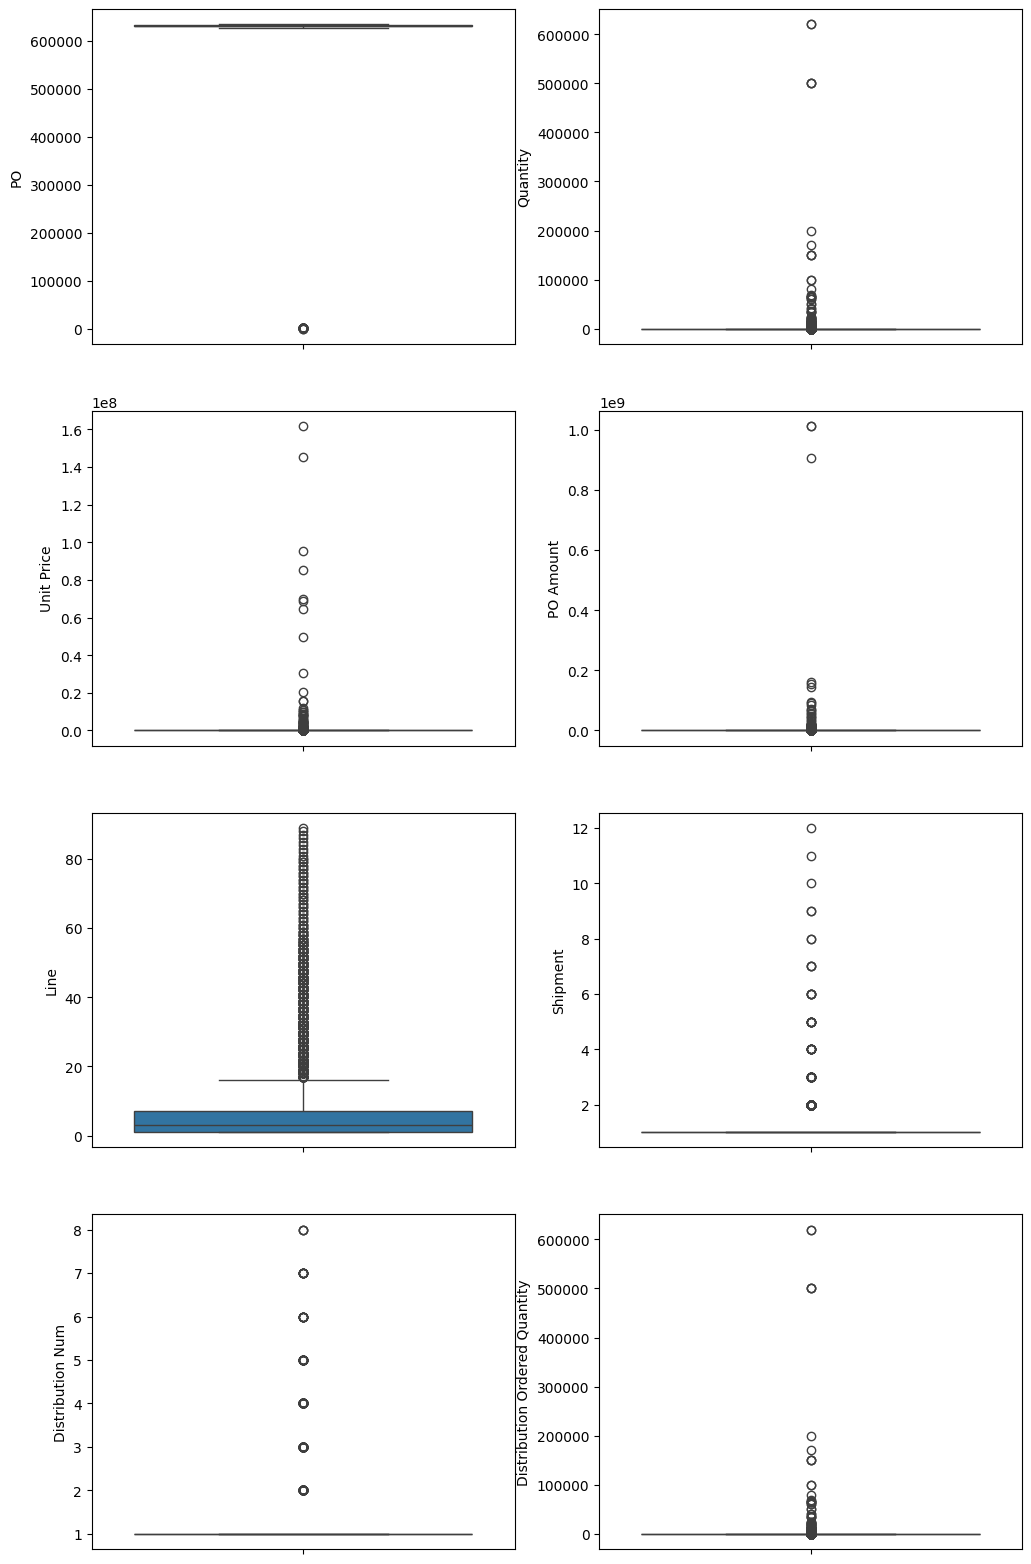

In [168]:
#calculate the number of fig to fit height
grid=(numeric_df.shape[1]+1)//2
#allocating each plot a height of 5
plt.figure(figsize=(12, grid * 5))

count=0
for col in numeric_df:
    count += 1
    plt.subplot(grid,2,count)
    sns.boxplot(y=df[col])


In [169]:
# Removing Outliers
for col in numeric_df:
    q1= df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    # calculating iqr
    iqr = q3 - q1

    #defining lower and upper bound
    upper= q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr

    # removing outliers
    df = df[(df[col] >= lower) & (df[col] <= upper)]


In [170]:
df.shape

(3712, 30)

## Visualisation

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

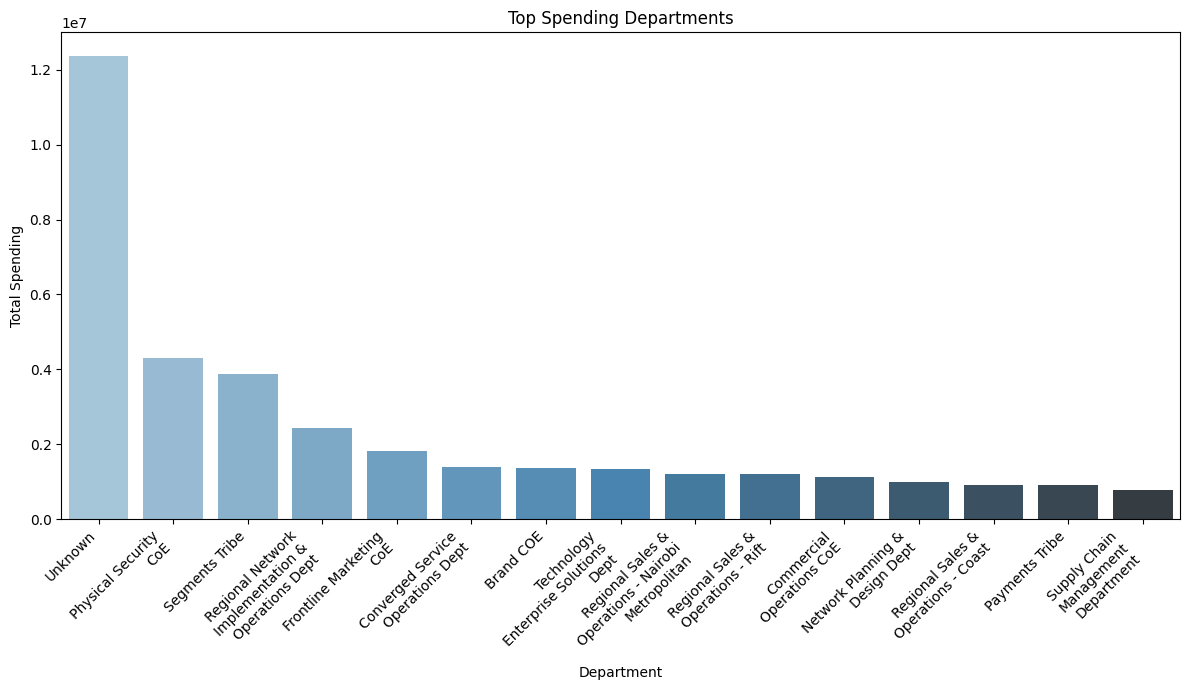

In [172]:
#top spending departments
top_departments = df.groupby('Department')['PO Amount'].sum().nlargest(15)
labels = ['\n'.join(textwrap.wrap(dept, 20)) for dept in top_departments.index]
plt.figure(figsize=(12, 7))
sns.barplot(x=labels, y=top_departments.values, palette="Blues_d")
plt.xlabel('Department')
plt.ylabel('Total Spending')
plt.title('Top Spending Departments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The unknown category contributes the largest share of spending, over Ksh 12M. This may indicate missing or unclassified data.Major spenders include:
Physical Security COE,Segments Tribe,Regional Network Implementation and  Operations.

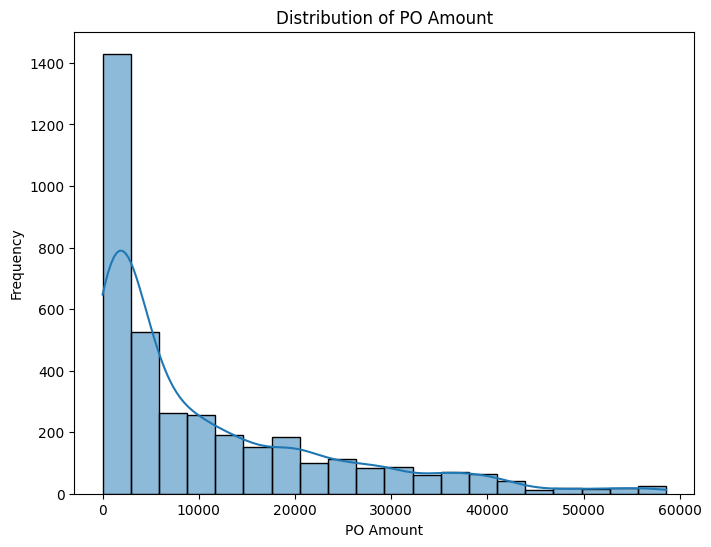

In [173]:
#PO Amount distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['PO Amount'], bins=20, kde=True)
plt.xlabel('PO Amount')
plt.ylabel('Frequency')
plt.title('Distribution of PO Amount')
plt.show()

The bulk of purchase orders fall below Ksh 5,000, suggesting many small-value transactions. We also have fewer, high value transactions beyond Ksh 20,000.

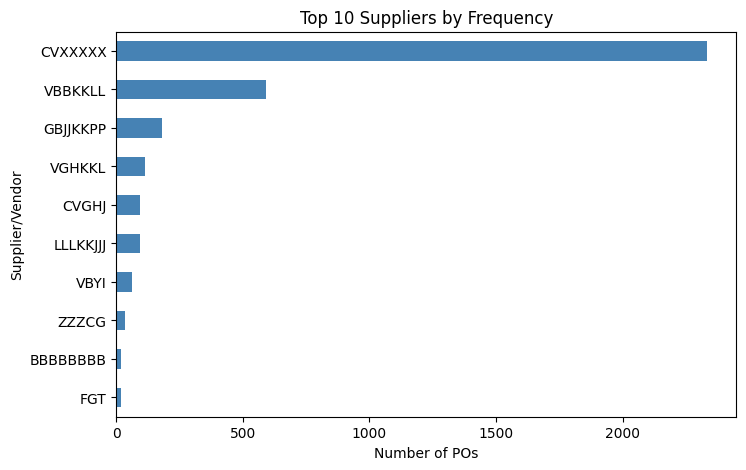

In [174]:
#Supplier frequency
# Get top 10 suppliers by frequency
supplier_counts = df['Supplier/Vendor'].value_counts().head(10)
ax = supplier_counts.plot(kind='barh', figsize=(8, 5), title='Top 10 Suppliers by Frequency', color='steelblue')
plt.xlabel('Number of POs')
plt.ylabel('Supplier/Vendor')
plt.gca().invert_yaxis()
plt.show()

CVXXXXX is the most engaged supplier with over 2,000 interactions, significantly ahead of others. This level of activity suggests a strong relationship but also raises a flag on dependency.

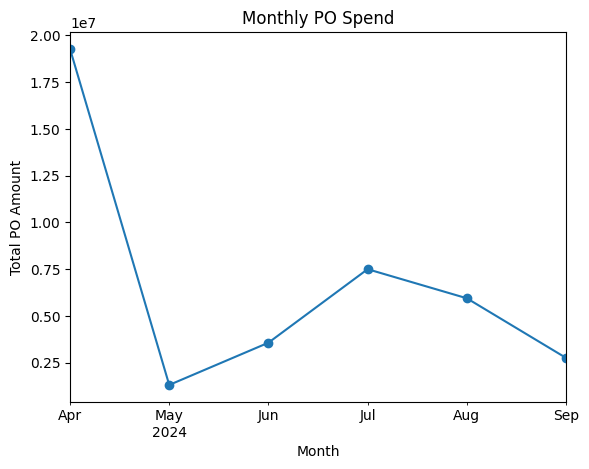

In [175]:
#Monthly trend of PO Amounts
df['Month'] = pd.to_datetime(df['Month'], errors='coerce')
monthly = df.groupby(df['Month'].dt.to_period('M'))['PO Amount'].sum()
monthly.plot(kind='line', marker='o', title='Monthly PO Spend')
plt.ylabel('Total PO Amount')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()

There is a major spike in PO spending in April 2024, likely tied to year end procurement. Then a dip in May followed by a gradual recovery in June and July.

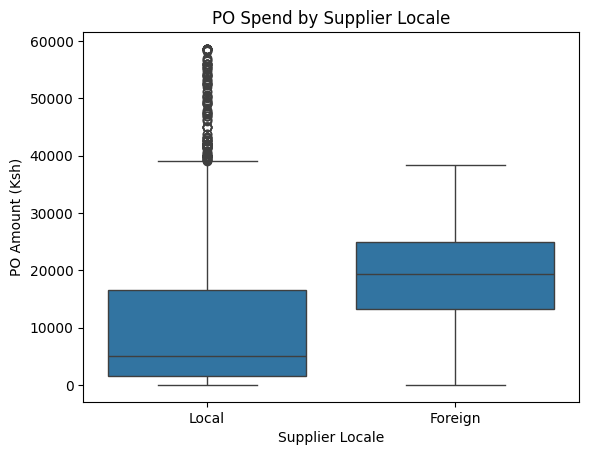

In [176]:
#PO Amount by Supplier Type (Local vs Foreign)
sns.boxplot(data=df, x='Locale(Foreign or Local based Suppliers)', y='PO Amount')
plt.xlabel('Supplier Locale')
plt.ylabel('PO Amount (Ksh)')
plt.title('PO Spend by Supplier Locale')
plt.show()

Foreign suppliers generally receive larger, more consistent PO amounts.Local suppliers handle many small orders and a few very large ones.

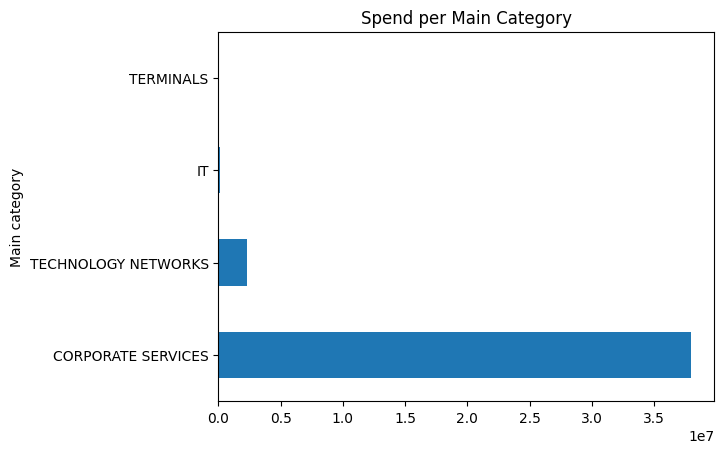

In [177]:
#Spend per Main category
main_cat_spend = df.groupby('Main category')['PO Amount'].sum().sort_values(ascending=False)
main_cat_spend.plot(kind='barh', title='Spend per Main Category')
plt.show()

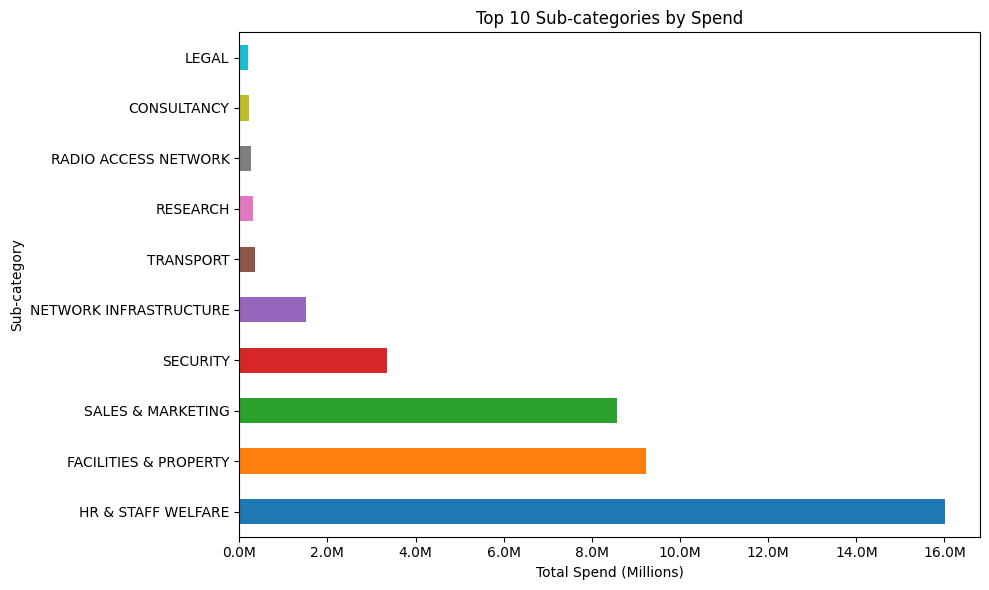

In [178]:
#Spend per Sub-category (top 10
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

sub_cat_spend = df.groupby('Sub-category')['PO Amount'].sum().sort_values(ascending=False).head(10)

# Define a color list
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots(figsize=(10, 6))
sub_cat_spend.plot(kind='barh', color=colors, ax=ax)
plt.title('Top 10 Sub-categories by Spend')
plt.xlabel('Total Spend (Millions)')
plt.ylabel('Sub-category')
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x*1e-6:.1f}M'))
plt.tight_layout()
plt.show()


HR & Staff Welfare, Facilities and  Property, and Sales and Marketing,Security dominate spending.

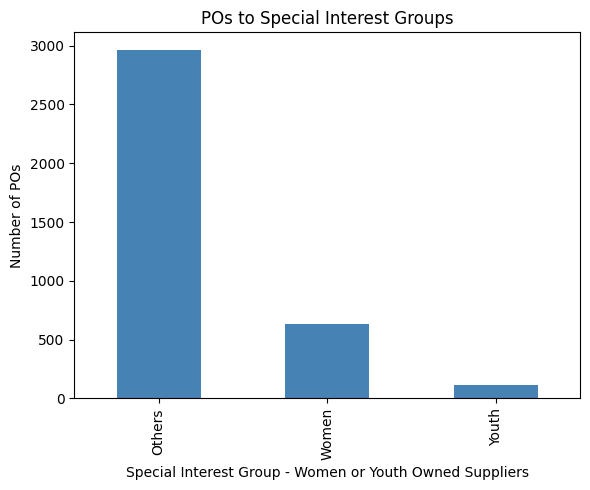

In [179]:
#Spend on Women/Youth-owned businesses
#Prepare data with clean labels
sig_counts = df['Special Interest Group- Women or Youth Owned Suppliers'].fillna('Others')
sig_counts = sig_counts.str.title().value_counts()
fig, ax = plt.subplots(figsize=(6, 5))
bars = sig_counts.plot(kind='bar', color='steelblue', ax=ax)
plt.title('POs to Special Interest Groups')
plt.xlabel('Special Interest Group - Women or Youth Owned Suppliers')
plt.ylabel('Number of POs')
plt.tight_layout()
plt.show()

The majority of POs are going to non-SIG (Others) suppliers.Women-owned suppliers receive a notable share while youth-owned suppliers are significantly underrepresented.

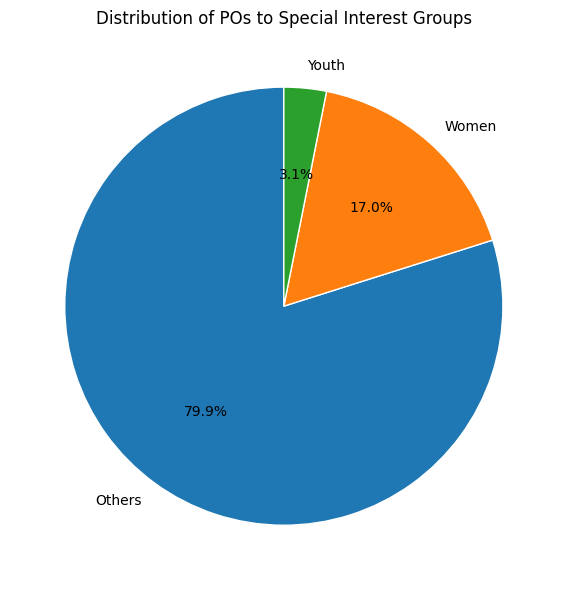

In [180]:
sig_counts = df['Special Interest Group- Women or Youth Owned Suppliers'].fillna('Others')
sig_counts = sig_counts.str.title().value_counts()
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    sig_counts,
    labels=sig_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#1f77b4', '#ff7f0e', '#2ca02c'],  # Optional: custom colors
    wedgeprops=dict(edgecolor='white')
)
ax.set_title('Distribution of POs to Special Interest Groups')
plt.tight_layout()
plt.show()


The majority of purchase orders go to suppliers outside of Special Interest Groups. Women-owned businesses account for 17%, and youth-owned suppliers are significantly underrepresented at just 3%.

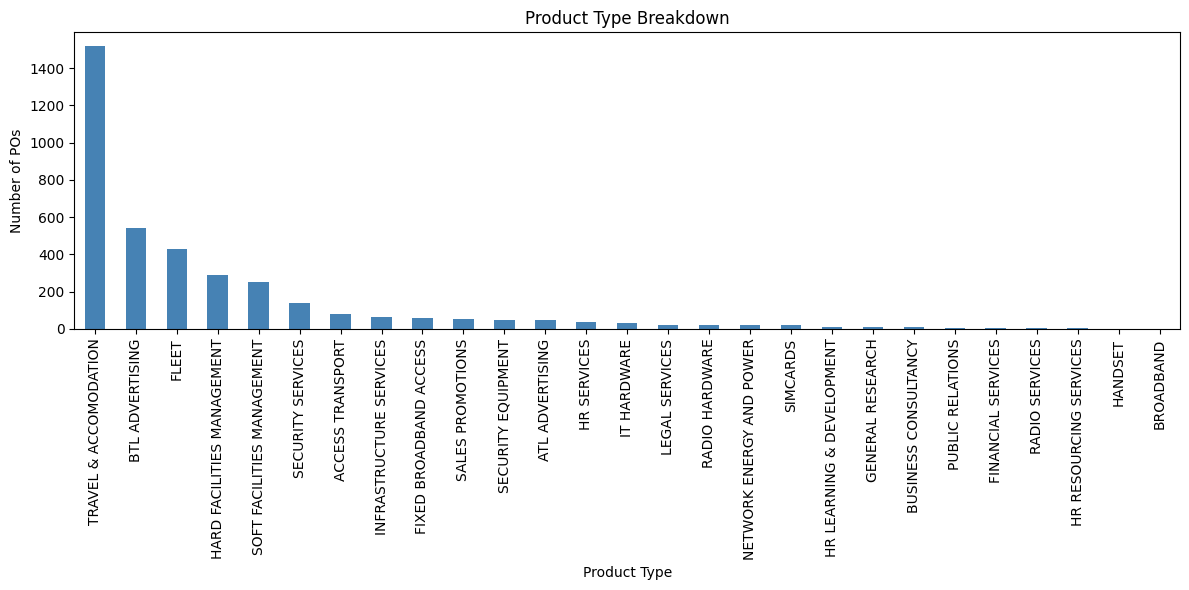

In [181]:
#Product Type breakdown
#Count POs by product type
product_counts = df['Product Type'].fillna('Unknown').value_counts()
fig, ax = plt.subplots(figsize=(12, 6))
product_counts.plot(kind='bar', color='steelblue', ax=ax)
plt.title('Product Type Breakdown')
plt.xlabel('Product Type')
plt.ylabel('Number of POs')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Most procurement activities centers around Travel & Accommodation, Advertising, and Facilities Management.

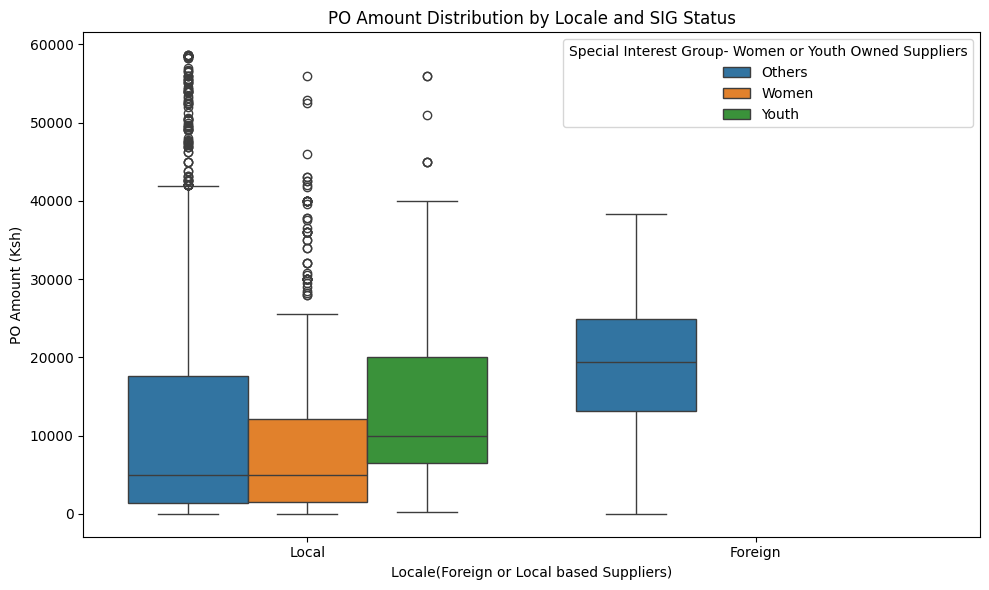

In [182]:
#PO Amount by Locale and SIG Status
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Locale(Foreign or Local based Suppliers)',
            y='PO Amount',
            hue='Special Interest Group- Women or Youth Owned Suppliers')
plt.title('PO Amount Distribution by Locale and SIG Status')
plt.ylabel('PO Amount (Ksh)')
plt.tight_layout()
plt.show()


This chart highlights a clear value disparity between local SIG suppliers and foreign or non-SIG vendors. While youth-owned suppliers have a higher median spend than women-owned ones, both are still on the lower end compared to others. Foreign suppliers consistently receive higher value POs, possibly due to specialization or contract size.

## Data Preprocessing

### Feature engineering

In [183]:
from sklearn.preprocessing import StandardScaler

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3712 entries, 59 to 8057
Data columns (total 30 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   OU Name                                                 3712 non-null   object        
 1   PO                                                      3712 non-null   int64         
 2   Month                                                   3712 non-null   datetime64[ns]
 3   PO/Release creation method                              3712 non-null   object        
 4   Supplier/Vendor                                         3712 non-null   object        
 5   Item Description                                        3712 non-null   object        
 6   Main category                                           3712 non-null   object        
 7   Sub-category                                            3712 non

In [185]:
df.head()

,OU Name,PO,Month,PO/Release creation method,Supplier/Vendor,Item Description,Main category,Sub-category,Product Type,Product Name,UOM,Currency,Quantity,Unit Price,PO Amount,Addressable or Non-Addressable,Locale(Foreign or Local based Suppliers),Special Interest Group- Women or Youth Owned Suppliers,Category Manager(s),Buyer,Closure Status,Type,Line,Shipment,Distribution Num,Distribution Ordered Quantity,Financial Year,Department,Division,Expenditure Type
59,Safaricom,627160,2024-08-01,Touchless,BVGT,Sales Brand Ambassador Transport Allowance,CORPORATE SERVICES,SALES & MARKETING,BTL ADVERTISING,AGENCY SERVICES - BTL,Each,KES,3.0,200.0,600.0,Addressable,Local,Others,Hesbon Ongira,"Karanja, Mrs. Maryanne",CLOSED,Goods,5,1,1,3.0,FY 2024/25,Payments Tribe,Financial Services Cluster,opex
60,Safaricom,627160,2024-08-01,Touchless,FFG,Experiential Vehicle Van Daily Hire Rate inclu...,CORPORATE SERVICES,SALES & MARKETING,BTL ADVERTISING,AGENCY SERVICES - BTL,Each,KES,1.0,10000.0,10000.0,Addressable,Local,Others,Muchiri Thomas,"Karanja, Mrs. Maryanne",CLOSED,Goods,6,1,1,1.0,FY 2024/25,Payments Tribe,Financial Services Cluster,opex
61,Safaricom,627160,2024-08-01,Touchless,BVGT,Cost of set up for experiential activation for...,CORPORATE SERVICES,SALES & MARKETING,BTL ADVERTISING,AGENCY SERVICES - EVENTS MANAGEMENT,Each,KES,1.0,8000.0,8000.0,Addressable,Local,Others,Hesbon Ongira,"Karanja, Mrs. Maryanne",CLOSED,Services,8,1,1,1.0,FY 2024/25,Payments Tribe,Financial Services Cluster,opex
62,Safaricom,627160,2024-08-01,Touchless,BVGT,Cost of set up for experiential activation for...,CORPORATE SERVICES,SALES & MARKETING,BTL ADVERTISING,AGENCY SERVICES - EVENTS MANAGEMENT,Each,KES,2.0,1800.0,3600.0,Addressable,Local,Others,Hesbon Ongira,"Karanja, Mrs. Maryanne",CLOSED,Services,10,1,1,2.0,FY 2024/25,Payments Tribe,Financial Services Cluster,opex
75,Safaricom,627301,2024-08-01,Touchless,BVGT,Driver Services Other Regions,CORPORATE SERVICES,HR & STAFF WELFARE,TRAVEL & ACCOMODATION,CAR HIRE,Each,KES,6.0,2000.0,12000.0,Addressable,Local,Others,"Muchiri, Mr. Thomas Kangangi","Karanja, Mrs. Maryanne",CLOSED,Goods,1,1,1,6.0,FY 2024/25,Unknown,Corporate Affairs Cluster,opex


In [186]:
# Extract months from the date provided
df['Month'] = df['Month'].dt.strftime('%B')

In [187]:
# Calculating total and average spend by product category, manager, department, month e.t.c.
agg_cols = [
    'OU Name','Type', 'Supplier/Vendor', 'Buyer', 'Category Manager(s)', 'Department',
    'Division', 'Main category', 'Sub-category', 'Expenditure Type'
]

for col in agg_cols:
    # Total spend per category
    total_spend = df.groupby(col)['PO Amount'].sum().rename(f'{col}_Total_Spend')
    df = df.merge(total_spend, on=col, how='left')

    # Average spend per category
    avg_spend = df.groupby(col)['PO Amount'].mean().rename(f'{col}_Avg_Spend')
    df = df.merge(avg_spend, on=col, how='left')


In [188]:
encode_cols = [
    'OU Name', 'Month', 'PO/Release creation method', 'Supplier/Vendor','Main category',
    'Sub-category', 'UOM', 'Currency','Addressable or Non-Addressable','Locale(Foreign or Local based Suppliers)',
    'Special Interest Group- Women or Youth Owned Suppliers', 'Category Manager(s)',
    'Buyer', 'Type','Department', 'Division',
    'Expenditure Type'
]

In [189]:
df = pd.get_dummies(df, columns=encode_cols, drop_first=True)

In [190]:
df.head()

,PO,Item Description,Product Type,Product Name,Quantity,Unit Price,PO Amount,Closure Status,Line,Shipment,Distribution Num,Distribution Ordered Quantity,Financial Year,OU Name_Total_Spend,OU Name_Avg_Spend,Type_Total_Spend,Type_Avg_Spend,Supplier/Vendor_Total_Spend,Supplier/Vendor_Avg_Spend,Buyer_Total_Spend,Buyer_Avg_Spend,Category Manager(s)_Total_Spend,...,Department_Technology Enterprise Solutions Dept,Department_Terminals CoE,Department_Unknown,Division_Brand Marketing Dept,Division_Business Development Cluster,Division_CEO Office,Division_Channels Cluster,Division_Consumer Business Unit,Division_Consumer Business Unit Cluster,Division_Corporate Affairs Cluster,Division_Corporate Security Cluster,Division_Customer Operations Division,Division_Digital IT,Division_Enterprise Business Unit Division,Division_Finance Cluster,Division_Financial Services Cluster,Division_Human Resources Cluster,Division_Network,Division_Technology Cluster,Division_Unknown,Expenditure Type_direct,Expenditure Type_opex
0,627160,Sales Brand Ambassador Transport Allowance,BTL ADVERTISING,AGENCY SERVICES - BTL,3.0,200.0,600.0,CLOSED,5,1,1,3.0,FY 2024/25,4.035560e+07,10871.659909,2.129785e+07,10170.893986,82163.01,6320.231538,4.032160e+07,10888.901716,2.561273e+07,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
1,627160,Experiential Vehicle Van Daily Hire Rate inclu...,BTL ADVERTISING,AGENCY SERVICES - BTL,1.0,10000.0,10000.0,CLOSED,6,1,1,1.0,FY 2024/25,4.035560e+07,10871.659909,2.129785e+07,10170.893986,121790.00,10149.166667,4.032160e+07,10888.901716,1.201170e+07,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
2,627160,Cost of set up for experiential activation for...,BTL ADVERTISING,AGENCY SERVICES - EVENTS MANAGEMENT,1.0,8000.0,8000.0,CLOSED,8,1,1,1.0,FY 2024/25,4.035560e+07,10871.659909,1.905775e+07,11778.584411,82163.01,6320.231538,4.032160e+07,10888.901716,2.561273e+07,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,627160,Cost of set up for experiential activation for...,BTL ADVERTISING,AGENCY SERVICES - EVENTS MANAGEMENT,2.0,1800.0,3600.0,CLOSED,10,1,1,2.0,FY 2024/25,4.035560e+07,10871.659909,1.905775e+07,11778.584411,82163.01,6320.231538,4.032160e+07,10888.901716,2.561273e+07,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
4,627301,Driver Services Other Regions,TRAVEL & ACCOMODATION,CAR HIRE,6.0,2000.0,12000.0,CLOSED,1,1,1,6.0,FY 2024/25,4.035560e+07,10871.659909,2.129785e+07,10170.893986,82163.01,6320.231538,4.032160e+07,10888.901716,9.730000e+05,...,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True


In [191]:
# Scaling
numerical_cols = ['Quantity', 'Unit Price', 'PO Amount', 'Distribution Ordered Quantity']

In [192]:
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [193]:
df.head()

,PO,Item Description,Product Type,Product Name,Quantity,Unit Price,PO Amount,Closure Status,Line,Shipment,Distribution Num,Distribution Ordered Quantity,Financial Year,OU Name_Total_Spend,OU Name_Avg_Spend,Type_Total_Spend,Type_Avg_Spend,Supplier/Vendor_Total_Spend,Supplier/Vendor_Avg_Spend,Buyer_Total_Spend,Buyer_Avg_Spend,Category Manager(s)_Total_Spend,...,Department_Technology Enterprise Solutions Dept,Department_Terminals CoE,Department_Unknown,Division_Brand Marketing Dept,Division_Business Development Cluster,Division_CEO Office,Division_Channels Cluster,Division_Consumer Business Unit,Division_Consumer Business Unit Cluster,Division_Corporate Affairs Cluster,Division_Corporate Security Cluster,Division_Customer Operations Division,Division_Digital IT,Division_Enterprise Business Unit Division,Division_Finance Cluster,Division_Financial Services Cluster,Division_Human Resources Cluster,Division_Network,Division_Technology Cluster,Division_Unknown,Expenditure Type_direct,Expenditure Type_opex
0,627160,Sales Brand Ambassador Transport Allowance,BTL ADVERTISING,AGENCY SERVICES - BTL,0.396995,-0.752667,-0.809187,CLOSED,5,1,1,0.446240,FY 2024/25,4.035560e+07,10871.659909,2.129785e+07,10170.893986,82163.01,6320.231538,4.032160e+07,10888.901716,2.561273e+07,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
1,627160,Experiential Vehicle Van Daily Hire Rate inclu...,BTL ADVERTISING,AGENCY SERVICES - BTL,-0.676046,0.331468,-0.068668,CLOSED,6,1,1,-0.713752,FY 2024/25,4.035560e+07,10871.659909,2.129785e+07,10170.893986,121790.00,10149.166667,4.032160e+07,10888.901716,1.201170e+07,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
2,627160,Cost of set up for experiential activation for...,BTL ADVERTISING,AGENCY SERVICES - EVENTS MANAGEMENT,-0.676046,0.110216,-0.226225,CLOSED,8,1,1,-0.713752,FY 2024/25,4.035560e+07,10871.659909,1.905775e+07,11778.584411,82163.01,6320.231538,4.032160e+07,10888.901716,2.561273e+07,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,627160,Cost of set up for experiential activation for...,BTL ADVERTISING,AGENCY SERVICES - EVENTS MANAGEMENT,-0.139525,-0.575665,-0.572851,CLOSED,10,1,1,-0.133756,FY 2024/25,4.035560e+07,10871.659909,1.905775e+07,11778.584411,82163.01,6320.231538,4.032160e+07,10888.901716,2.561273e+07,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
4,627301,Driver Services Other Regions,TRAVEL & ACCOMODATION,CAR HIRE,2.006555,-0.553540,0.088889,CLOSED,1,1,1,2.186227,FY 2024/25,4.035560e+07,10871.659909,2.129785e+07,10170.893986,82163.01,6320.231538,4.032160e+07,10888.901716,9.730000e+05,...,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True


## Text preprocessing

In [194]:
df[["Item Description"]].sample(7)

,Item Description
3397,Launch cakeNakuru Franchise shop Launch Rift A...
1878,Mombasa MIA One Way Saloon Airport Transfer 11...
816,Hotel Booking for George Njuguna at Mara Intep...
956,Using Express Way
2099,BCD Accommodation and transfers for Nyokabi Fl...
501,Service for B for KBZ 368S Job Barini s offici...
1447,Catering Levy 2 Mobile Data Tribe Mission Stra...


In [195]:
df[["Item Description"]].isna().sum()

,0
Item Description,0


### Lowercasing
Convert all `tweet_text` to lowercase to maintain consistency

In [196]:
df["Item Description Clean"] = df["Item Description"].str.lower()

We did lowercasing to make texts uniform

**Function to handle text processing**

In [197]:
def text_pattern_check(process, pattern):
    def extract_pattern(text):
        if isinstance(text, str):
            return re.findall(pattern, text)
        return []

    # apply pattern extraction
    links_list = df['Item Description Clean'].apply(extract_pattern)

    # flatten the list of lists
    all_links = [link for sublist in links_list for link in sublist]

    # check if anything was found
    if all_links:
        print(f"{process} found in the dataset: {len(all_links)} matches")
        print(all_links[:5])  # optional: show a few samples
    else:
        print(f"No {process} found.")

- Replaced abreviation with its full form so as they won't be removed as stopwords

**Removing pattern function**

In [198]:
def remove_pattern(pattern):
    df["Item Description Clean"] = df["Item Description Clean"].apply(lambda x: re.sub(pattern, '', x))

**Replacing abbreviation with its full form**

In [199]:
# loading abbreviation dictionary from abbr.txt
with open('abbr.txt', 'r') as file:
    abbr_dict = json.load(file)

In [200]:
def check_abbr():
    # Function to check if a text contains any abbreviation
    def contains_abbr(text):
        return any(word in abbr_dict for word in text.split())

    # Filter texts that contain abbreviations
    abbr_text = df[df["Item Description Clean"].apply(contains_abbr)]

    # Check if any were found and print message + examples
    if not abbr_text.empty:
        print("Abbreviations found in some texts. Here are a few examples:")
        print(abbr_text[["Item Description Clean"]].head(5))
    else:
        print("No abbreviations found in any texts.")
check_abbr()


Abbreviations found in some texts. Here are a few examples:
                                Item Description Clean
39   misc tie wraps insulating tape cable lugs stap...
46   misc tie wraps insulating tape cable lugs stap...
55   misc tie wraps insulating tape cable lugs stap...
66   misc tie wraps insulating tape cable lugs stap...
187  highlight travel ltd domestic flight jm change...


In [201]:
# expand abbreviations in a tweet
def expand_abbr_in_tweet(text):
    return " ".join([abbr_dict.get(word, word) for word in text.split()])

# apply the function to each tweet in the DataFrame
df["Item Description Clean"] = df["Item Description Clean"].apply(expand_abbr_in_tweet)

In [202]:
check_abbr()

No abbreviations found in any texts.


**Removing Numbers**

Checking if any numbers exist

In [203]:
text_pattern_check('Numbers', r'\b\d+\b')

Numbers found in the dataset: 3267 matches
['40', '40', '40', '40', '2024']


In [204]:
remove_pattern(r'\b\d+\b')

In [205]:
text_pattern_check('Numbers', r'\b\d+\b')

No Numbers found.


**Removing Dates**

In [206]:
text_pattern_check('Dates',r'\b([1-9]|[12][0-9]|3[01])(st|nd|rd|th)\b')

Dates found in the dataset: 1282 matches
[('7', 'th'), ('18', 'th'), ('18', 'th'), ('23', 'rd'), ('23', 'rd')]


In [207]:
remove_pattern(r'\b([1-9]|[12][0-9]|3[01])(st|nd|rd|th)\b')

In [208]:
text_pattern_check('Dates',r'\b([1-9]|[12][0-9]|3[01])(st|nd|rd|th)\b')

No Dates found.


**Removing Punctuation**

In [209]:
def check_punctuation():
    rows = df[df["Item Description Clean"].apply(lambda x: any(c in string.punctuation for c in x))]
    if not rows.empty:
        print("Punctuation found. Examples:\n", rows["Item Description Clean"].head(5))
    else:
        print("No punctuation found.")

check_punctuation()

No punctuation found.


In [210]:
# remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# applying the function to the Item Description column
df["Item Description Clean"] = df["Item Description Clean"].apply(remove_punctuation)

In [211]:
check_punctuation()

No punctuation found.


**Removing Stopwords**

In [212]:
# getting stopwords
stopwords_list = stopwords.words('english')

#removing punctuation from stopwords since punctuation have been removed
stopwords_list= [word.translate(str.maketrans('', '', string.punctuation)) for word in stopwords_list]


In [213]:
for index in range(df["Item Description Clean"].shape[0]):
    text = df["Item Description Clean"].iloc[index].split()
    #removing stopwords from text
    text_no_stopword = " ".join([word for word in text if word not in stopwords_list])
    df["Item Description Clean"].iloc[index] = text_no_stopword

### Tokenization

In [214]:
for index in range(df["Item Description Clean"].shape[0]):
    df["Item Description Clean"].iloc[index] = word_tokenize(df["Item Description Clean"].iloc[index])

### Lemmatization

In [215]:
lemmatizer = WordNetLemmatizer()

for index in range(df["Item Description Clean"].shape[0]):
    text = df["Item Description Clean"].iloc[index]
    text =[lemmatizer.lemmatize(word) for word in text]
    df["Item Description Clean"].iloc[index] = text

In [216]:
# Prepared the text
df['Item Description Clean'] = [" ".join(text) for text in df['Item Description Clean']]


In [217]:
df[["Item Description","Item Description Clean"]]

,Item Description,Item Description Clean
0,Sales Brand Ambassador Transport Allowance,sale brand ambassador transport allowance
1,Experiential Vehicle Van Daily Hire Rate inclu...,experiential vehicle van daily hire rate inclu...
2,Cost of set up for experiential activation for...,cost set experiential activation globalpay wom...
3,Cost of set up for experiential activation for...,cost set experiential activation globalpay wom...
4,Driver Services Other Regions,driver service region
...,...,...
3707,Kakamega Golf Service Charge Deluxe Room,kakamega golf service charge deluxe room
3708,Kakamega Golf Hotel Catering Levy Deluxe Room,kakamega golf hotel catering levy deluxe room
3709,Siaya Candela Hotel Catering Levy,siaya candela hotel catering levy
3710,Siaya Candela Hotel Service Charge,siaya candela hotel service charge


## Vectorizing

In [218]:
from sklearn.feature_extraction.text import  TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf_matrix = tfidf_vect.fit_transform(df['Item Description'])
tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vect.get_feature_names_out())

df = pd.concat([df,tfidf], axis=1)

# Now df contains the embeddings as a new column
df.head(5)

,PO,Item Description,Product Type,Product Name,Quantity,Unit Price,PO Amount,Closure Status,Line,Shipment,Distribution Num,Distribution Ordered Quantity,Financial Year,OU Name_Total_Spend,OU Name_Avg_Spend,Type_Total_Spend,Type_Avg_Spend,Supplier/Vendor_Total_Spend,Supplier/Vendor_Avg_Spend,Buyer_Total_Spend,Buyer_Avg_Spend,Category Manager(s)_Total_Spend,...,x600,xhp,xpress,ya,ydx,year,yellow,yogo,young,youth,yr,ysk,yusuf,yvonne,zamara,zebu,zero,zoilr,zone,zre151,zre182r,zuena
0,627160,Sales Brand Ambassador Transport Allowance,BTL ADVERTISING,AGENCY SERVICES - BTL,0.396995,-0.752667,-0.809187,CLOSED,5,1,1,0.446240,FY 2024/25,4.035560e+07,10871.659909,2.129785e+07,10170.893986,82163.01,6320.231538,4.032160e+07,10888.901716,2.561273e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,627160,Experiential Vehicle Van Daily Hire Rate inclu...,BTL ADVERTISING,AGENCY SERVICES - BTL,-0.676046,0.331468,-0.068668,CLOSED,6,1,1,-0.713752,FY 2024/25,4.035560e+07,10871.659909,2.129785e+07,10170.893986,121790.00,10149.166667,4.032160e+07,10888.901716,1.201170e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,627160,Cost of set up for experiential activation for...,BTL ADVERTISING,AGENCY SERVICES - EVENTS MANAGEMENT,-0.676046,0.110216,-0.226225,CLOSED,8,1,1,-0.713752,FY 2024/25,4.035560e+07,10871.659909,1.905775e+07,11778.584411,82163.01,6320.231538,4.032160e+07,10888.901716,2.561273e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,627160,Cost of set up for experiential activation for...,BTL ADVERTISING,AGENCY SERVICES - EVENTS MANAGEMENT,-0.139525,-0.575665,-0.572851,CLOSED,10,1,1,-0.133756,FY 2024/25,4.035560e+07,10871.659909,1.905775e+07,11778.584411,82163.01,6320.231538,4.032160e+07,10888.901716,2.561273e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,627301,Driver Services Other Regions,TRAVEL & ACCOMODATION,CAR HIRE,2.006555,-0.553540,0.088889,CLOSED,1,1,1,2.186227,FY 2024/25,4.035560e+07,10871.659909,2.129785e+07,10170.893986,82163.01,6320.231538,4.032160e+07,10888.901716,9.730000e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
